# atmodeller

## Tutorial 5: silicon

Import the required functionality.

In [5]:
from atmodeller import debug_logger, debug_file_logger
from atmodeller.constraints import SystemConstraints, ElementMassConstraint, BufferedFugacityConstraint, TotalPressureConstraint, ActivityConstraint
from atmodeller.thermodata.redox_buffers import IronWustiteBuffer
from atmodeller.interior_atmosphere import InteriorAtmosphereSystem, Planet
from atmodeller.initial_solution import InitialSolutionDict, InitialSolution #InitialSolutionRegressor, InitialSolutionSwitchRegressor, InitialSolutionConstant
from atmodeller.core import GasSpecies, Species, LiquidSpecies
from atmodeller.solubility.hydrogen_species import H2_basalt_hirschmann, H2O_peridotite_sossi
from atmodeller.utilities import earth_oceans_to_kg
from atmodeller.eos.interfaces import RealGas
from atmodeller.eos.saxena import get_saxena_eos_models, H2_SS92
from atmodeller.eos.holland import get_holland_eos_models, H2_CORK_HP91
from atmodeller.eos.holley import get_holley_eos_models, H2_Beattie_holley
from atmodeller.eos.chabrier import get_chabrier_eos_models, H2_CD21

model_holland = H2_CORK_HP91
model_holley = H2_Beattie_holley
model_saxena = H2_SS92
model_chabrier = H2_CD21

eos_models: dict[str, RealGas] = get_chabrier_eos_models() # get_saxena_eos_models() # get_holley_eos_models() # get_holland_eos_models()

import logging
# logger = debug_file_logger()
logger = debug_logger()
logger.setLevel(logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from atmodeller.eos.chabrier import get_chabrier_eos_models
models = get_chabrier_eos_models()
# List the available species
models.keys()
# Get the EOS model for H2
h2_model = models['H2']
# Determine the fugacity coefficient at 2000 K and 1000 bar
fugacity_coefficient = h2_model.fugacity_coefficient(temperature=3000, pressure=100000)
print(fugacity_coefficient)

In [ ]:
from atmodeller.eos.saxena import get_saxena_eos_models
models = get_saxena_eos_models()
# List the available species
models.keys()
# Get the EOS model for H2
h2_model = models['H2']
# Determine the fugacity coefficient at 2000 K and 1000 bar
fugacity_coefficient = h2_model.fugacity_coefficient(temperature=3000, pressure=100000)
print(fugacity_coefficient)

In [ ]:
from atmodeller.eos.holley import get_holley_eos_models
models = get_holley_eos_models()
# List the available species
models.keys()
# Get the EOS model for H2
h2_model = models['H2']
# Determine the fugacity coefficient at 2000 K and 1000 bar
fugacity_coefficient = h2_model.fugacity_coefficient(temperature=3000, pressure=100000)
print(fugacity_coefficient)

### 1. Compare H2 fugacity coefficients

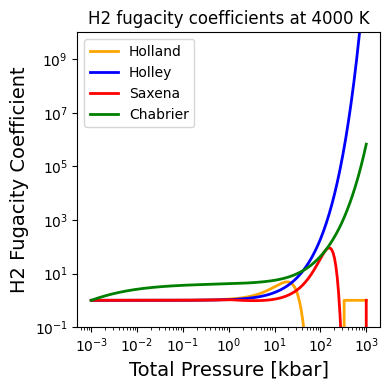

In [17]:
pressures = np.logspace(0, 6, num=200)
temperature = 3000 #k


fc_holland = []
fc_holley = []
fc_saxena = []
fc_chabrier = []

for pressure in pressures:
    fc_holland.append(model_holland.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_holley.append(model_holley.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_saxena.append(model_saxena.fugacity_coefficient(temperature=temperature, pressure=pressure))
    fc_chabrier.append(model_chabrier.fugacity_coefficient(temperature=temperature, pressure=pressure))

fig, ax1 = plt.subplots(1, figsize=(4,4), tight_layout='True')

ax1.plot(pressures/1e3, fc_holland, color='orange', lw=2, label=r'Holland')
ax1.plot(pressures/1e3, fc_holley, color='blue', lw=2, label=r'Holley')
ax1.plot(pressures/1e3, fc_saxena, color='red', lw=2, label=r'Saxena')
ax1.plot(pressures/1e3, fc_chabrier, color='green', lw=2, label=r'Chabrier')

ax1.set_title('H2 fugacity coefficients at %d K'%temperature)

ax1.set_ylim([0.1,1e10])

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'Total Pressure [kbar]', fontsize=14)
ax1.set_ylabel(r'H2 Fugacity Coefficient', fontsize=14)

# ax2.set_xlabel(r"log $f_{\rm O_2}$ ($\Delta$IW)", fontsize=14)
# ax2.set_ylabel(r"$P_{\rm total}$ [kbar]", fontsize=14)

# ax1a.set_ylabel(r"$P_{\rm surface}$ [kbar]", fontsize=14)
ax1.legend(ncol=1, loc='upper left')
plt.savefig('H2fugcoeff_%dK.pdf'%temperature, bbox_inches='tight')
plt.savefig('H2fugcoeff_%dK.png'%temperature, bbox_inches='tight')
plt.show()

### 2. Example

In [7]:
logger: logging.Logger = debug_file_logger()

massH_ocean = 200 # mass of H equivalent to water oceans
h_kg: float = earth_oceans_to_kg(massH_ocean)
total_pressure = 50000 # bar
logfO2_shift = 3 # deltaIW = 0 by default

surface_temperature=3400 # kelvin
planet_mass=11*5.972e24 # kg
surface_radius=1.7*6371000 # metre

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2O_g, H2_g, O2_g, OSi_g, H4Si_g, O2Si_l])

constraints: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=logfO2_shift)),
        #TotalPressureConstraint(value=total_pressure),
        ElementMassConstraint("H", value=h_kg),
        ActivityConstraint(O2Si_l, 1),
    ]
)

system = InteriorAtmosphereSystem(species=species, planet=planet)

values = {H2_g: 600, H2O_g: 60000, O2_g: 1e-8, OSi_g: 0.1, H4Si_g: 1e-8, O2Si_l: 1}

initial_solution = InitialSolutionDict(value=values, species=species)  

system.solve(constraints)
   
solution = system.solution_dict()
solution['total_pressure'] = system.total_pressure
solution['log_fO2_dIW'] = np.log10(solution['O2_g']) - IronWustiteBuffer().get_log10_value(
    temperature=system.planet.surface_temperature, pressure=system.total_pressure)

logger.info("Ideal solution = %s", solution)

# Dan edits below. Get the initial condition from the solution array for the ideal gas. Below can
# be cleaned up. In general it's good to leave the solution dictionary as pristine, but since other
# data has been added we can just take the solutions for the gas species and the activity of the
# liquid

# Ideal solution, to use as the IC for the non-ideal case.

initial_condition = np.array([value for value in solution.values()][:6])

# Now turn on non-ideality

# Non-ideal H2
H2_g = GasSpecies("H2", eos=eos_models["H2"])
#### Re-defining remaining species
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

# assigning initial conditions from the ideal solution
values = {H2_g: initial_condition[0], H2O_g: initial_condition[1], O2_g: initial_condition[2], 
          OSi_g: initial_condition[3], H4Si_g: initial_condition[4], O2Si_l: initial_condition[5]}

initial_solution = InitialSolutionDict(value=values, species=species)  

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

constraints: SystemConstraints = SystemConstraints(
    [
        BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=logfO2_shift)),
        #TotalPressureConstraint(value=total_pressure),
        ElementMassConstraint("H", value=h_kg),
        ActivityConstraint(O2Si_l, 1),
    ]
)

system = InteriorAtmosphereSystem(species=species, planet=planet, initial_solution=initial_solution)

# Pass in ideal solution as the initial condition for the real gas system
system.solve(constraints, factor=0.1, tol=1e-6, initial_solution=initial_solution)

solution = system.solution_dict()
solution['total_pressure'] = system.total_pressure
solution['log_fO2_dIW'] = np.log10(solution['O2_g']) - IronWustiteBuffer().get_log10_value(
    temperature=system.planet.surface_temperature, pressure=system.total_pressure)

logger.info("Real solution = %s", solution)

[14:35:37 - atmodeller.interior_atmosphere - INFO     ] - Creating a new planet
[14:35:37 - atmodeller.interior_atmosphere - INFO     ] - planet_mass = 6.5692e+25
[14:35:37 - atmodeller.interior_atmosphere - INFO     ] - core_mass_fraction = 0.295334691460966
[14:35:37 - atmodeller.interior_atmosphere - INFO     ] - mantle_melt_fraction = 1.0
[14:35:37 - atmodeller.interior_atmosphere - INFO     ] - surface_radius = 10830700.0
[14:35:37 - atmodeller.interior_atmosphere - INFO     ] - surface_temperature = 3400
[14:35:37 - atmodeller.interior_atmosphere - INFO     ] - melt_composition = None
[14:35:37 - atmodeller.interior_atmosphere - INFO     ] - mantle_mass = 4.629087344854622e+25
[14:35:37 - atmodeller.interior_atmosphere - INFO     ] - mantle_melt_mass = 4.629087344854622e+25
[14:35:37 - atmodeller.interior_atmosphere - INFO     ] - mantle_solid_mass = 0.0
[14:35:37 - atmodeller.interior_atmosphere - INFO     ] - surface_area = 1474086323819288.0
[14:35:37 - atmodeller.interior_atm

### 3. H2/H2O ratio variation: H2O-H2-O2-SiO-SiH4-O2Sil system (ideal, no solubility) 

In [11]:
massH_ocean = 200 # mass of H equivalent to water oceans
h_kg: float = earth_oceans_to_kg(massH_ocean)
# total_pressure = 50000 # bar

surface_temperature=3400 # kelvin
planet_mass=11*5.972e24 # kg
surface_radius=1.7*6371000 # metre

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Ideal gases (no solubility)
H2_g = GasSpecies("H2")
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

log_fO2_dIWs = np.linspace(-4, 2, num=100) 

constraints = []

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW)),
            #TotalPressureConstraint(value=total_pressure),
            ElementMassConstraint("H", value=h_kg),
            ActivityConstraint(O2Si_l, 1),
        ]
    )
    constraints.append(constraint)

system = InteriorAtmosphereSystem(species=species, planet=planet)

solutions = []

for constraint in constraints:

    system.solve(constraint)
    solution = system.solution_dict()
    solution['total_pressure'] = system.total_pressure
    solution['log_fO2_dIW'] = np.log10(solution['O2_g']) - IronWustiteBuffer().get_log10_value(
        temperature=system.planet.surface_temperature, pressure=system.total_pressure)

    fug_coeff = model_chabrier.fugacity_coefficient(temperature=surface_temperature, pressure=solution['total_pressure'])
    solution['fugacity_coefficient'] = fug_coeff
    solutions.append(solution)

filename = "SiOH_nosolubility_ideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

[14:36:54 - atmodeller.interior_atmosphere - INFO     ] - Creating a new planet
[14:36:54 - atmodeller.interior_atmosphere - INFO     ] - planet_mass = 6.5692e+25
[14:36:54 - atmodeller.interior_atmosphere - INFO     ] - core_mass_fraction = 0.295334691460966
[14:36:54 - atmodeller.interior_atmosphere - INFO     ] - mantle_melt_fraction = 1.0
[14:36:54 - atmodeller.interior_atmosphere - INFO     ] - surface_radius = 10830700.0
[14:36:54 - atmodeller.interior_atmosphere - INFO     ] - surface_temperature = 3400
[14:36:54 - atmodeller.interior_atmosphere - INFO     ] - melt_composition = None
[14:36:54 - atmodeller.interior_atmosphere - INFO     ] - mantle_mass = 4.629087344854622e+25
[14:36:54 - atmodeller.interior_atmosphere - INFO     ] - mantle_melt_mass = 4.629087344854622e+25
[14:36:54 - atmodeller.interior_atmosphere - INFO     ] - mantle_solid_mass = 0.0
[14:36:54 - atmodeller.interior_atmosphere - INFO     ] - surface_area = 1474086323819288.0
[14:36:54 - atmodeller.interior_atm

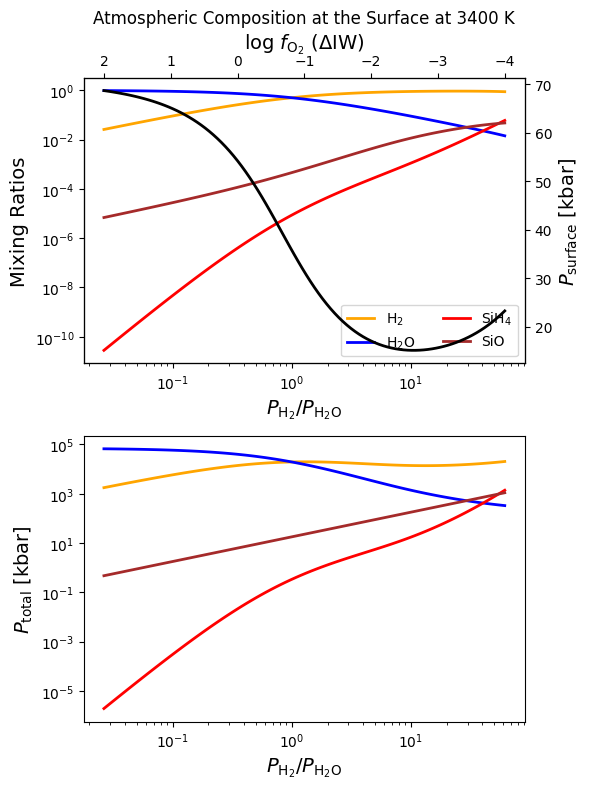

In [12]:
df = pd.read_csv(filename) 
ratio = df['H2_g'].values / df['H2O_g'].values
logfO2 = df['log_fO2_dIW'].values
H2 = df['H2_g'].values
H2O = df['H2O_g'].values
SiH4 = df['H4Si_g'].values
SiO = df['OSi_g'].values
O2 = df['O2_g'].values
tot = df['total_pressure'].values
fc = df['fugacity_coefficient'].values

fig, (ax1, ax3) = plt.subplots(2, figsize=(6,8), tight_layout='True')

# ax1.set_ylim([1e-10,1.2])
# ax1.axvspan(2.6e-2, 1e0, alpha=0.2, color='blue')
# ax1.axvspan(1e0, 2e2, alpha=0.2, color='green')
# ax1.axvspan(2e2, 3e3, alpha=0.2, color='red')

ax1a = ax1.twinx()
ax2 = ax1a.twiny()
ax2.invert_xaxis()
ax2.plot(logfO2, tot/1000, color='black', lw=2, label=r'$P_{\rm surface}$', zorder=0)

# ax1.text(3e-2, 1e-3, 'Steam Worlds', fontsize=10)
# ax1.text(3, 1e-5, 'Hydrogen Worlds', fontsize=10)
# ax1.text(2e2, 1e-7, 'Silicon Worlds', fontsize=10)

ax1.plot(ratio, H2/tot, color='orange', lw=2, label=r'H$_2$')
ax1.plot(ratio, H2O/tot, color='blue', lw=2, label=r'H$_2$O')
ax1.plot(ratio, SiH4/tot, color='red', lw=2, label=r'SiH$_4$')
ax1.plot(ratio, SiO/tot, color='brown', lw=2, label=r'SiO')

ax1.set_title('Atmospheric Composition at the Surface at %d K'%surface_temperature)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$P_{\rm H_2}/P_{\rm H_2O}$', fontsize=14)
ax1.set_ylabel(r'Mixing Ratios', fontsize=14)

ax2.set_xlabel(r"log $f_{\rm O_2}$ ($\Delta$IW)", fontsize=14)
ax2.set_ylabel(r"$P_{\rm total}$ [kbar]", fontsize=14)
#ax2.set_ylim([0,1.1e2])

ax3.set_xscale('log')
ax3.set_yscale('log')

ax3.set_xlabel(r"$P_{\rm H_2}/P_{\rm H_2O}$", fontsize=14)
ax3.set_ylabel(r"$P_{\rm total}$ [kbar]", fontsize=14)

ax3.plot(ratio, H2, color='orange', lw=2, label=r'H$_2$')
ax3.plot(ratio, H2O, color='blue', lw=2, label=r'H$_2$O')
ax3.plot(ratio, SiH4, color='red', lw=2, label=r'SiH$_4$')
ax3.plot(ratio, SiO, color='brown', lw=2, label=r'SiO')

ax1a.set_ylabel(r"$P_{\rm surface}$ [kbar]", fontsize=14)
ax1.legend(ncol=2, loc='lower right')
plt.savefig("SiOH_nosolubility_ideal_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOH_nosolubility_ideal_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()

### 4. H2/H2O ratio variation: H2O-H2-O2-SiO-SiH4-O2Sil system (non-ideal, no solubility) 

In [13]:
df = pd.read_csv(filename) 
df = df[['H2_g', 'H2O_g', 'O2_g', 'OSi_g', 'H4Si_g', 'O2Si_l']]
#df['H2'] = df['H2'] * adjust_sol(df['H2']) 
#df['H4Si'] = df['H4Si'] / adjust_sol(df['H2']) **2
insols = df.to_numpy()

massH_ocean = 200 # mass of H equivalent to water oceans
h_kg: float = earth_oceans_to_kg(massH_ocean)
# total_pressure = 50000 # bar

surface_temperature=3400 # kelvin
planet_mass=11*5.972e24 # kg
surface_radius=1.7*6371000 # metre

planet = Planet(surface_temperature=surface_temperature, planet_mass=planet_mass, 
                  surface_radius=surface_radius)

# Non-ideal H2
H2_g = GasSpecies("H2", eos=eos_models["H2"])
#### Re-defining remaining species 
H2O_g = GasSpecies("H2O")        
O2_g = GasSpecies("O2")
OSi_g = GasSpecies("OSi")
H4Si_g = GasSpecies("H4Si")
O2Si_l = LiquidSpecies("O2Si")

species = Species([H2_g, H2O_g, O2_g, OSi_g, H4Si_g, O2Si_l])

log_fO2_dIWs = np.linspace(-4, 2, num=100) 

constraints = []

for log_fO2_dIW in log_fO2_dIWs:

    constraint: SystemConstraints = SystemConstraints(
        [
            BufferedFugacityConstraint(O2_g, IronWustiteBuffer(log10_shift=log_fO2_dIW)),
            #TotalPressureConstraint(value=total_pressure),
            ElementMassConstraint("H", value=h_kg),
            ActivityConstraint(O2Si_l, 1),
        ]
    )
    constraints.append(constraint)

system = InteriorAtmosphereSystem(species=species, planet=planet)

solutions = []

for (log_fO2_dIW, constraint, insol) in zip(log_fO2_dIWs, constraints, insols):

    values = {H2_g: insol[0], H2O_g: insol[1], O2_g: insol[2], OSi_g: insol[3], H4Si_g: insol[4], O2Si_l: insol[5]}

    initial_solution = InitialSolutionDict(values, species=species)

    system.solve(constraint, initial_solution=initial_solution)
    
    solution = system.solution_dict()
    solution['total_pressure'] = system.total_pressure
    solution['log_fO2_dIW'] = np.log10(solution['O2_g']) - IronWustiteBuffer().get_log10_value(
        temperature=system.planet.surface_temperature, pressure=system.total_pressure)
    
    fug_coeff = model_chabrier.fugacity_coefficient(temperature=surface_temperature, pressure=solution['total_pressure'])
    solution['fugacity_coefficient'] = fug_coeff
    solutions.append(solution)

filename = "SiOH_nosolubility_nonideal_%dK_%docean.csv"%(surface_temperature,massH_ocean)
df = pd.DataFrame(solutions)
df.to_csv(filename, encoding='utf-8', index=False)

system.output("nonideal.xlsx", to_excel=True, to_pickle=True)

[14:37:09 - atmodeller.interior_atmosphere - INFO     ] - Creating a new planet
[14:37:09 - atmodeller.interior_atmosphere - INFO     ] - planet_mass = 6.5692e+25
[14:37:09 - atmodeller.interior_atmosphere - INFO     ] - core_mass_fraction = 0.295334691460966
[14:37:09 - atmodeller.interior_atmosphere - INFO     ] - mantle_melt_fraction = 1.0
[14:37:09 - atmodeller.interior_atmosphere - INFO     ] - surface_radius = 10830700.0
[14:37:09 - atmodeller.interior_atmosphere - INFO     ] - surface_temperature = 3400
[14:37:09 - atmodeller.interior_atmosphere - INFO     ] - melt_composition = None
[14:37:09 - atmodeller.interior_atmosphere - INFO     ] - mantle_mass = 4.629087344854622e+25
[14:37:09 - atmodeller.interior_atmosphere - INFO     ] - mantle_melt_mass = 4.629087344854622e+25
[14:37:09 - atmodeller.interior_atmosphere - INFO     ] - mantle_solid_mass = 0.0
[14:37:09 - atmodeller.interior_atmosphere - INFO     ] - surface_area = 1474086323819288.0
[14:37:09 - atmodeller.interior_atm

{'H2_g': [{'atmosphere_mass': 7.440273210134173e+21,
   'atmosphere_moles': 3.690827741968118e+24,
   'atmosphere_ppmw': 36764.747492058545,
   'atmosphere_ppm': 366349.37437447684,
   'atmosphere_fugacity': 153555.78681892407,
   'atmosphere_fugacity_coefficient': 8.16829096752043,
   'atmosphere_pressure': 18799.010396361708,
   'atmosphere_volume_mixing_ratio': 0.36634937437447684,
   'melt_mass': 0.0,
   'melt_moles': 0.0,
   'melt_ppmw': 0.0,
   'solid_mass': 0.0,
   'solid_moles': 0.0,
   'solid_ppmw': 0,
   'total_mass': 7.440273210134173e+21,
   'total_moles': 3.690827741968118e+24,
   'molar_mass': 0.002015882},
  {'atmosphere_mass': 8.070702473246938e+21,
   'atmosphere_moles': 4.003558974804546e+24,
   'atmosphere_ppmw': 40739.35301336821,
   'atmosphere_ppm': 389692.7506540847,
   'atmosphere_fugacity': 155161.13774523197,
   'atmosphere_fugacity_coefficient': 7.926494835160472,
   'atmosphere_pressure': 19575.000169932056,
   'atmosphere_volume_mixing_ratio': 0.38969275065

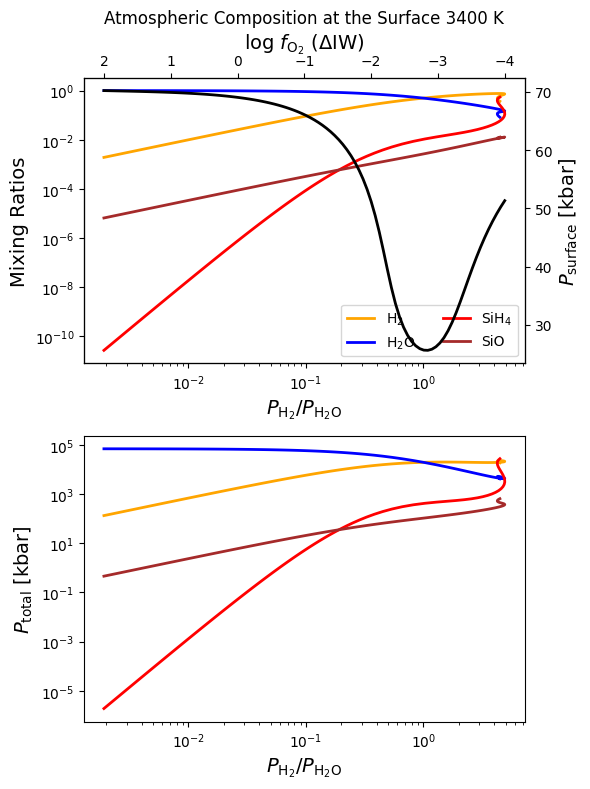

In [14]:
df = pd.read_csv(filename) 
ratio = df['H2_g'].values / df['H2O_g'].values
logfO2 = df['log_fO2_dIW'].values
H2 = df['H2_g'].values
H2O = df['H2O_g'].values
SiH4 = df['H4Si_g'].values
SiO = df['OSi_g'].values
O2 = df['O2_g'].values
tot = df['total_pressure'].values
fc = df['fugacity_coefficient'].values

fig, (ax1, ax3) = plt.subplots(2, figsize=(6,8), tight_layout='True')

# ax1.set_ylim([1e-10,1.2])
# ax1.axvspan(2.6e-2, 1e0, alpha=0.2, color='blue')
# ax1.axvspan(1e0, 2e2, alpha=0.2, color='green')
# ax1.axvspan(2e2, 3e3, alpha=0.2, color='red')

ax1a = ax1.twinx()
ax2 = ax1a.twiny()
ax2.invert_xaxis()
ax2.plot(logfO2, tot/1000, color='black', lw=2, label=r'$P_{\rm surface}$', zorder=0)

# ax1.text(3e-2, 1e-3, 'Steam Worlds', fontsize=10)
# ax1.text(3, 1e-5, 'Hydrogen Worlds', fontsize=10)
# ax1.text(2e2, 1e-7, 'Silicon Worlds', fontsize=10)

ax1.plot(ratio, H2/tot, color='orange', lw=2, label=r'H$_2$')
ax1.plot(ratio, H2O/tot, color='blue', lw=2, label=r'H$_2$O')
ax1.plot(ratio, SiH4/tot, color='red', lw=2, label=r'SiH$_4$')
ax1.plot(ratio, SiO/tot, color='brown', lw=2, label=r'SiO')

ax1.set_title('Atmospheric Composition at the Surface %d K'%surface_temperature)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r'$P_{\rm H_2}/P_{\rm H_2O}$', fontsize=14)
ax1.set_ylabel(r'Mixing Ratios', fontsize=14)

ax2.set_xlabel(r"log $f_{\rm O_2}$ ($\Delta$IW)", fontsize=14)
ax2.set_ylabel(r"$P_{\rm total}$ [kbar]", fontsize=14)

ax1a.set_ylabel(r"$P_{\rm surface}$ [kbar]", fontsize=14)
ax1.legend(ncol=2, loc='lower right')

ax3.set_xscale('log')
ax3.set_yscale('log')

ax3.set_xlabel(r"$P_{\rm H_2}/P_{\rm H_2O}$", fontsize=14)
ax3.set_ylabel(r"$P_{\rm total}$ [kbar]", fontsize=14)

ax3.plot(ratio, H2, color='orange', lw=2, label=r'H$_2$')
ax3.plot(ratio, H2O, color='blue', lw=2, label=r'H$_2$O')
ax3.plot(ratio, SiH4, color='red', lw=2, label=r'SiH$_4$')
ax3.plot(ratio, SiO, color='brown', lw=2, label=r'SiO')

plt.savefig("SiOH_nosolubility_nonideal_%dK_%docean.pdf"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.savefig("SiOH_nosolubility_nonideal_%dK_%docean.png"%(surface_temperature,massH_ocean), bbox_inches='tight')
plt.show()